In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of Data

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [63]:
# Convert to 0-4 labeling and integer type (integers needed for categorical labels)
y_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')
y_test = (y_test - np.min(y_test)).astype('int')

In [7]:
# Dense layer
in_features = 8
out_features = 5
x = torch.zeros(7, in_features)
layer = nn.Linear(in_features, out_features)
print(x.shape, layer(x).shape)

torch.Size([7, 8]) torch.Size([7, 5])


In [8]:
with torch.no_grad():
    layer.weight[:] = 0.0

In [101]:
# # Sequential layers
# sequential = nn.Sequential(
#     nn.LazyLinear(17),
#     nn.LazyLinear(19)
# )
# print(x.shape, sequential(x).shape)

In [10]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=12345)
X_train = torch.FloatTensor(X_train_np).to(device)
X_val = torch.FloatTensor(X_val_np).to(device)
y_train = torch.LongTensor(y_train_np).to(device)
y_val = torch.LongTensor(y_val_np).to(device)

### Convert data types of tensors 

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X) # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y) # integer type
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [12]:
batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

In [56]:
len(train_dataset), len(train_dataloader)

(1692, 27)

### RNN

In [18]:
import tqdm # for progress bar

In [68]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim=22, hidden_dim=20, output_dim=4):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        # TODO: add nn.?? for the second neural network
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h_0=None):
        # x has shape (batch_size, input_dim, timesteps)
        # h_0 has shape (D*num_layers, hidden_dim)

        z = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        if h_0 is None:
            z, hn = self.rnn(z) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        else:
            # We detach h_0 (not required, just recommended) so that the computational graph does not extend too far.
            z, hn = self.rnn(z, h_0.detach()) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        # hn is the stored hidden state after computation
        out = self.fc(z[:, -1, :])
        out = F.relu(out)  # add ReLU activation function
        return out

In [69]:
# Note that sometimes RNNs run faster on cpu, but usually only if they're small.
#device = torch.device('cpu')

model = RNNClassifier(22, 64, 4).to(device)
optimizer = torch.optim.Adam(model.parameters())
celoss = nn.CrossEntropyLoss()

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

In [67]:
num_epochs = 50

# progress bar
pbar = tqdm.tqdm(
    range(num_epochs), position=0, leave=True,
    bar_format='{l_bar}{bar:30}{r_bar}',
)
for epoch in pbar:
    model.train() # set model to training mode.
    for batch in train_dataloader:
        optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
        x, y = batch

        # x = x.to(device) # necessary if X is not on the same device as model
        # y = y.to(device)

        out = model(x) # shape (batch_size, n_classes)
        loss = celoss(out, y) # calculate the cross entropy loss

        loss.backward() # backpropagate
        optimizer.step() # perform optimization step

        # IMPORTANT: DO NOT store 'loss' by itself, since it references its entire computational graph.
        # Otherwise you will run out of memory.
        # You MUST use .item() to convert to a scalar or call .detach().
        loss_hist.append(loss.item())
    
    model.eval() # set model to evaluation mode.
    # calculate accuracy for training and validation sets
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            out = model(x)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            out = model(x)
            loss = celoss(out, y)
            val_loss_hist.append(loss.item())
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    val_acc_hist.append(nc/ns)


    # update progress bar postfix
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

100%|██████████████████████████████| 50/50 [08:24<00:00, 10.09s/it, acc=0.832, val_acc=0.277]


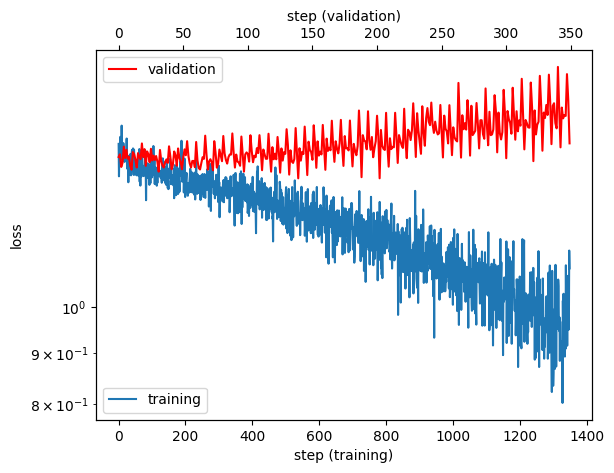

In [26]:
plt.figure(dpi=100)
plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')

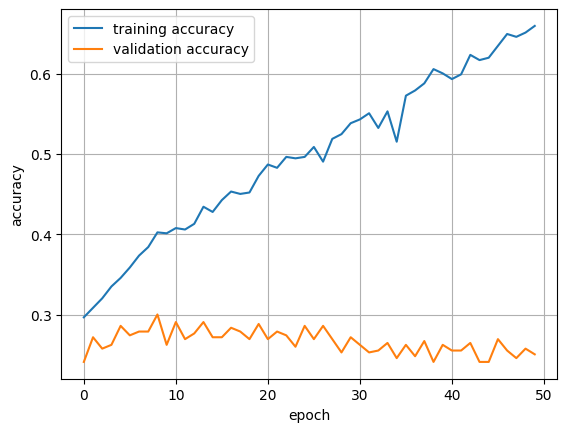

In [27]:
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()

In [64]:
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

model.eval() # Set model to evaluation mode
with torch.no_grad():
    out = model(X_test_tensor)
    test_acc = (out.argmax(dim=1) == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.2528
